In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from causalinference import CausalModel

import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [3]:
data = pd.read_csv("learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


In [4]:
data['success_expect']

0        6
1        4
2        6
3        6
4        6
        ..
10386    7
10387    7
10388    2
10389    5
10390    5
Name: success_expect, Length: 10391, dtype: int64

In [5]:
data.groupby("success_expect")["intervention"].mean().reset_index()

,success_expect,intervention
0,1,0.271739
1,2,0.265957
2,3,0.294118
3,4,0.271617
4,5,0.311070
5,6,0.354287
6,7,0.362319


In [6]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


In [7]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      achievement_score   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     535.1
Date:                Thu, 02 Sep 2021   Prob (F-statistic):          1.74e-115
Time:                        18:47:16   Log-Likelihood:                -14483.
No. Observations:               10391   AIC:                         2.897e+04
Df Residuals:                   10389   BIC:                         2.898e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1538      0.012    -13.201      0.000      -0.177      -0.131
intervention     0.4723      0.020     23.133      0.000       0.432       0.512
==============================================================================
Omnibus:                       46.208   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.932
Skew:                           0.116   Prob(JB):                     7.84e-10
Kurtosis:                       2.792   Cond. No.                         2.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

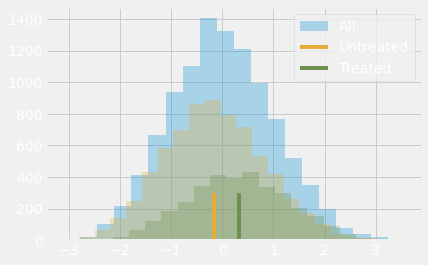

In [8]:
plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend();

In [9]:
categ = ["ethnicity", "gender", "school_urbanicity"] # Categorical
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"] # Contiguous

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

In [10]:
data_with_categ

,schoolid,intervention,achievement_score,...,school_urbanicity_2,school_urbanicity_3,school_urbanicity_4
0,76,1,0.277359,...,0,0,1
1,76,1,-0.449646,...,0,0,1
2,76,1,0.769703,...,0,0,1
3,76,1,-0.121763,...,0,0,1
4,76,1,1.526147,...,0,0,1
...,...,...,...,...,...,...,...
10386,1,0,0.808867,...,0,1,0
10387,1,0,-0.156063,...,0,1,0
10388,1,0,0.370820,...,0,1,0
10389,1,0,-0.396297,...,0,1,0


In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

In [13]:
ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

In [14]:
ps_model.predict_proba(data_with_categ[X])

array([[0.6845344 , 0.3154656 ],
       [0.73638281, 0.26361719],
       [0.65597256, 0.34402744],
       ...,
       [0.75040381, 0.24959619],
       [0.69710891, 0.30289109],
       [0.74394299, 0.25605701]])

In [15]:
data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

In [16]:
data_ps[["intervention", "achievement_score", "propensity_score"]].head()

,intervention,achievement_score,propensity_score
0,1,0.277359,0.315466
1,1,-0.449646,0.263617
2,1,0.769703,0.344027
3,1,-0.121763,0.344027
4,1,1.526147,0.367820


In [17]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])

In [18]:

print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10388.777750704134
Untreated Population Sample Size 10391.390537092764


<AxesSubplot:xlabel='success_expect', ylabel='propensity_score'>

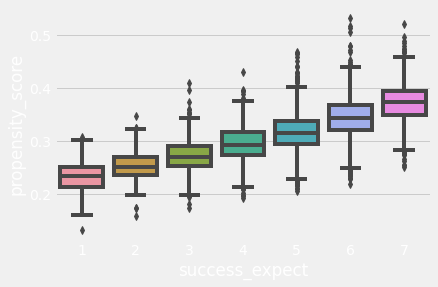

In [19]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)

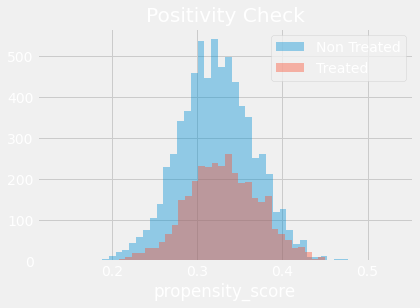

In [20]:
sns.distplot(data_ps.query("intervention==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("intervention==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

In [21]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0 = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

In [22]:
ate = np.mean(weight * data_ps["achievement_score"]) # Average treatment effect
ate

0.38848331048216755

In [23]:
y1 - y0

0.3884833104821677

In [24]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

/Users/boyanxu/anaconda3/envs/causal_inference/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/boyanxu/anaconda3/envs/causal_inference/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

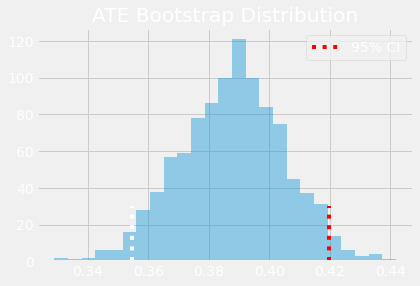

In [25]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", color="red",label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

In [26]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.38774507084643645
95% C.I.: (0.3545138010444087, 0.4199276388406872)


In [27]:
np.random.seed(42)
school_a = pd.DataFrame(dict(T=np.random.binomial(1, .99, 400), school=0, intercept=1))
school_b = pd.DataFrame(dict(T=np.random.binomial(1, .01, 400), school=1, intercept=1))
ex_data  = pd.concat([school_a, school_b]).assign(y = lambda d: np.random.normal(1 + 0.1 * d["T"]))
ex_data.head()

,T,school,intercept,y
0,1,0,1,0.309526
1,1,0,1,1.571468
2,1,0,1,2.982024
3,1,0,1,2.445420
4,1,0,1,2.693187


In [36]:
df = ex_data
X = ["school"]
T = "T"
y = "y"
ps = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1]

weight = (df[T]-ps) / (ps*(1-ps)) # define the weights

ps_df = df.assign(ps=ps, weight=weight, iptw=df[y]*weight)

In [39]:
ps_df

,T,school,intercept,...,ps,weight,iptw
0,1,0,1,...,0.9950,1.005025,0.311081
1,1,0,1,...,0.9950,1.005025,1.579365
2,1,0,1,...,0.9950,1.005025,2.997010
3,1,0,1,...,0.9950,1.005025,2.457709
4,1,0,1,...,0.9950,1.005025,2.706720
...,...,...,...,...,...,...,...
395,0,1,1,...,0.0075,-1.007557,-1.942408
396,0,1,1,...,0.0075,-1.007557,-1.065001
397,0,1,1,...,0.0075,-1.007557,-1.278178
398,0,1,1,...,0.0075,-1.007557,-2.547575


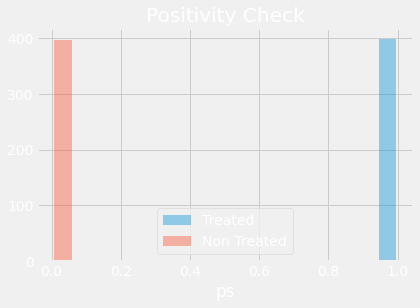

In [40]:
# plt.hist(ps_df.query("T==1")["ps"], bins=20, alpha=0.3, color="C2", label='Treatment')
# plt.hist(ps_df.query("T==0")["ps"], bins=20, alpha=0.3, color="C3", label='control')
# plt.legend()

sns.distplot(ps_df.query("T==1")["ps"], kde=False, label="Treated")
sns.distplot(ps_df.query("T==0")["ps"], kde=False, label="Non Treated")
plt.title("Positivity Check")
plt.legend();


<AxesSubplot:xlabel='school', ylabel='ps'>

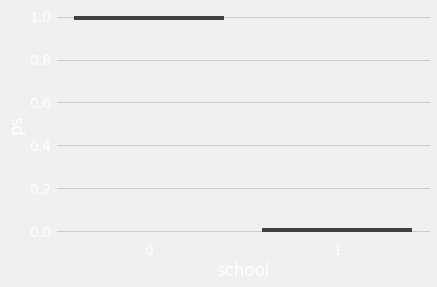

In [38]:
sns.boxplot(x="school", y="ps", data=ps_df)

In [88]:
ate_w_f  = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["school"], "T", "y") for _ in range(500)])
ate_wo_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["intercept"], "T", "y") for _ in range(500)])

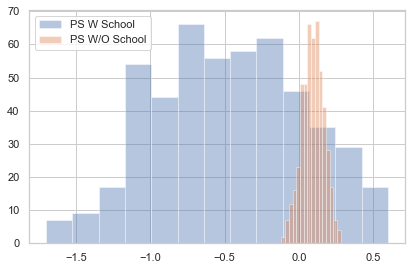

In [89]:
sns.distplot(ate_w_f, kde=False, label="PS W School")
sns.distplot(ate_wo_f, kde=False, label="PS W/O School")
plt.legend();

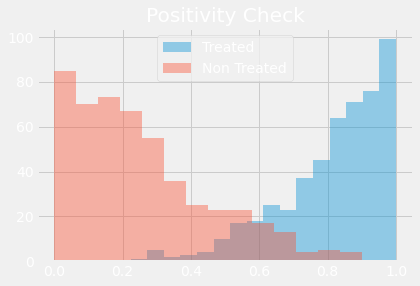

In [42]:
sns.distplot(np.random.beta(4,1,500), kde=False, label="Treated")
sns.distplot(np.random.beta(1,3,500), kde=False, label="Non Treated")
plt.title("Positivity Check")
plt.legend();

In [43]:
smf.ols("achievement_score ~ intervention + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.0760,0.065,-47.064,0.000,-3.204,-2.948
intervention,0.3930,0.019,20.974,0.000,0.356,0.430
propensity_score,9.0523,0.200,45.316,0.000,8.661,9.444


In [44]:
cm = CausalModel(
    Y=data_ps["achievement_score"].values, 
    D=data_ps["intervention"].values, 
    X=data_ps[["propensity_score"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)